In [1]:
# !pip install SimpleITK opencv-python -q

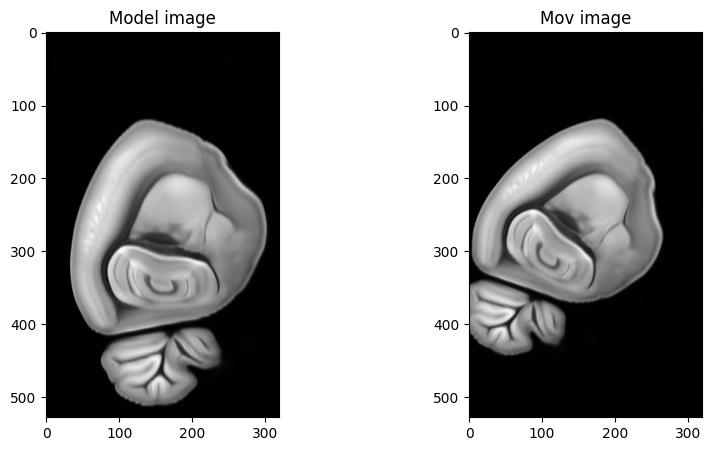

In [2]:
import numpy as np
import pandas as pd
import cv2
import SimpleITK as sitk
import matplotlib.pyplot as plt
from pathlib import Path

# --- 2. Load our test samples ---
BASE_DIR = Path("./project_data")
RAW_ATLAS_DIR = BASE_DIR / "raw_atlas_slices"
SYNTHETIC_TEST_DIR = BASE_DIR / "test_synthetic"
gt_df = pd.read_csv(SYNTHETIC_TEST_DIR / "ground_truth.csv")

# Also select the first sample for demonstration
index = gt_df.iloc[0]
A1 = SYNTHETIC_TEST_DIR / "images" / index["synthetic_file"]
A = RAW_ATLAS_DIR / index["source_file"]

# Load the image
A = cv2.imread(str(A), cv2.IMREAD_GRAYSCALE)
A1 = cv2.imread(str(A1), cv2.IMREAD_GRAYSCALE)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(A, cmap='gray')
axes[0].set_title("Model image")
axes[1].imshow(A1, cmap='gray')
axes[1].set_title("Mov image")
plt.show()

In [3]:
print(A.dtype)
print(A[200])

uint8
[  0   0   1   1   1   1   2   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   2
   1   1   1   1   1   0   0   6  55 115 145 148 143 139 140 143 149 156
 162 167 174 178 182 184 189 193 196 200 203 207 209 213 215 217 219 218
 220 219 220 222 224 224 223 220 217 213 210 208 207 205 207 207 207 207
 207 205 202 199 195 194 191 188 186 183 180 178 174 171 168 166 161 157
 153 149 145 140 135 129 124 119 115 110 106 103 101 100 100 100 100 100
 100  99  98  95  91  87  82  78  74  74  79  88 100 113 126 138 149 158
 168 168 173 180 183 188 190 193 197 199 199 202 205 207 207 208 208 208
 208 209 208 205 206 205 204 201 200 197 195 191 188 185 180 177 171 166
 163 157 152 147 142 136 131 126 122 120 116 114 114 114 115 115 117 117
 117 115 114 110 109 106 106 106 106 106 106 106 109 110 114 115 118 121
 123 125 127 129 130 131 131 132 132 132 131 

Number of candidate slices: 218
[1/218] Skipping coronal_slice_000.png: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: D:\a\SimpleITK\SimpleITK\bld\ITK-prefix\include\ITK-5.4\itkImageBase.hxx:79:
ITK ERROR: Image(000002656F2E1610): Zero-valued spacing is not supported and may result in undefined behavior.
Refusing to change spacing from [1, 1] to [0, 3.83338]
[133/218] Skipping horizontal_slice_000.png: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: D:\a\SimpleITK\SimpleITK\bld\ITK-prefix\include\ITK-5.4\itkImageBase.hxx:79:
ITK ERROR: Image(00000265726AA300): Zero-valued spacing is not supported and may result in undefined behavior.
Refusing to change spacing from [1, 1] to [0, 3.83338]
[173/218] Skipping sagittal_slice_000.png: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: D:\a\SimpleITK\SimpleITK\bld\ITK-prefix\include\ITK-5.4\itkImageBase.hxx:79:
ITK ERROR: Image(0000026572644070): Zero-valued spacing is not supported and may result 

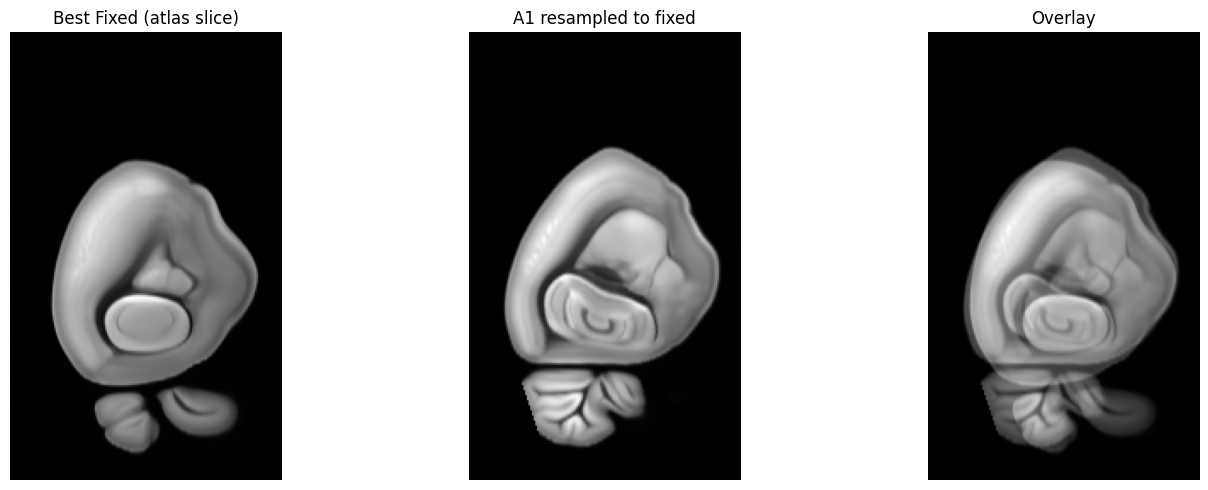

In [4]:
# --- Retrieve the most similar slices from the entire library based on mutual information ---
from typing import List, Tuple
import math

# Adjustable parameters
TOP_K = 5                   # Returns the top K most similar slices
DOWNSAMPLE_FACTOR = 2       # Downsample first to accelerate (>1 means downsampling)
HIST_BINS = 64              # Number of bins for the mutual information histogram
SAMPLE_PERCENT = 0.2        # Sampling percentage for mutual information (for registration)
MAX_ITER = 150              # Maximum number of iterations per slice
ROT_RANGE_DEG = 20          # Allowable initial small-angle disturbance (helps to escape local optima), can be increased as needed

# Convert numpy grayscale image to sitk image and downsample
def to_sitk_gray(img_np, down=1):
    if down > 1:
        img_np = cv2.resize(img_np, (img_np.shape[1]//down, img_np.shape[0]//down), interpolation=cv2.INTER_AREA)
    img_sitk = sitk.GetImageFromArray(img_np.astype(np.float32))
    return img_sitk

# Generate binary mask (to ignore pure black background)
def make_mask(img_np, down=1, thresh=0, min_pixels=50):
    # Simply using ">0" as foreground to avoid discarding weak gray values as background
    if down > 1:
        img_np = cv2.resize(img_np, (img_np.shape[1]//down, img_np.shape[0]//down), interpolation=cv2.INTER_NEAREST)
    m = (img_np > thresh).astype(np.uint8)
    if m.sum() < min_pixels:
        return None  # If there are too few pixels, discard the mask
    return sitk.GetImageFromArray(m)

# Normalized Mutual Information (NMI), used for sorting after alignment
def normalized_mutual_information(x, y, mask=None, bins=64):
    # Flatten and filter by mask
    x = x.astype(np.float32).ravel()
    y = y.astype(np.float32).ravel()
    if mask is not None:
        m = mask.astype(bool).ravel()
        if m.sum() == 0:
            return -np.inf
        x = x[m]
        y = y[m]
    # Adaptive intensity range (to exclude effects of extreme black backgrounds)
    x_min, x_max = np.percentile(x, 1), np.percentile(x, 99)
    y_min, y_max = np.percentile(y, 1), np.percentile(y, 99)
    x = np.clip(x, x_min, x_max)
    y = np.clip(y, y_min, y_max)

    # Joint histogram
    H, _, _ = np.histogram2d(x, y, bins=bins)
    Pxy = H / np.maximum(H.sum(), 1.0)
    Px = Pxy.sum(axis=1, keepdims=True)
    Py = Pxy.sum(axis=0, keepdims=True)

    # Avoid log(0)
    eps = 1e-12
    Hx = -np.sum(Px * np.log(Px + eps))
    Hy = -np.sum(Py * np.log(Py + eps))
    Hxy = -np.sum(Pxy * np.log(Pxy + eps))
    return (Hx + Hy) / max(Hxy, eps)

def register_and_score(fixed_np, moving_np, hist_bins=HIST_BINS, sample_percent=SAMPLE_PERCENT,
                       max_iter=MAX_ITER, down=DOWNSAMPLE_FACTOR) -> Tuple[float, sitk.Transform, np.ndarray, np.ndarray]:
    fixed = to_sitk_gray(fixed_np, down=down)
    moving = to_sitk_gray(moving_np, down=down)

    fixed_mask = make_mask(fixed_np, down=down, thresh=0)
    moving_mask = make_mask(moving_np, down=down, thresh=0)

    def _run(mask_fixed, mask_moving, sampling='RANDOM'):
        R = sitk.ImageRegistrationMethod()
        R.SetMetricAsMattesMutualInformation(numberOfHistogramBins=hist_bins)
        if sampling == 'RANDOM':
            R.SetMetricSamplingStrategy(R.RANDOM)
            R.SetMetricSamplingPercentage(sample_percent)
        else:
            R.SetMetricSamplingStrategy(R.NONE)
        if mask_fixed is not None:
            R.SetMetricFixedMask(mask_fixed)
        if mask_moving is not None:
            R.SetMetricMovingMask(mask_moving)
        R.SetInterpolator(sitk.sitkLinear)
        R.SetShrinkFactorsPerLevel([4, 2, 1])
        R.SetSmoothingSigmasPerLevel([2, 1, 0])
        R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

        initial_tx = sitk.CenteredTransformInitializer(
            fixed, moving, sitk.Similarity2DTransform(),
            sitk.CenteredTransformInitializerFilter.GEOMETRY
        )
        if ROT_RANGE_DEG > 0:
            angle_rad = np.deg2rad(np.random.uniform(-ROT_RANGE_DEG, ROT_RANGE_DEG))
            initial_tx.SetAngle(initial_tx.GetAngle() + float(angle_rad))

        R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                                   minStep=1e-3,
                                                   numberOfIterations=max_iter,
                                                   relaxationFactor=0.5,
                                                   gradientMagnitudeTolerance=1e-6)
        R.SetOptimizerScalesFromPhysicalShift()
        R.SetInitialTransform(initial_tx, inPlace=False)
        final_tx = R.Execute(fixed, moving)
        moved = sitk.Resample(moving, fixed, final_tx, sitk.sitkLinear, 0.0, sitk.sitkFloat32)
        return final_tx, moved

    # 1) Preferred: with mask + random sampling
    try:
        final_tx, moved = _run(fixed_mask, moving_mask, sampling='RANDOM')
    except Exception:
        # 2) Fallback: Remove the mask
        try:
            final_tx, moved = _run(None, None, sampling='RANDOM')
        except Exception:
            # 3) Fallback: No sampling (full image), throw an error if it still fails
            final_tx, moved = _run(None, None, sampling='NONE')

    moved_np = sitk.GetArrayFromImage(moved)
    fixed_np_ds = sitk.GetArrayFromImage(fixed)

    joint_mask = ((moved_np > 0) & (fixed_np_ds > 0)).astype(np.uint8)
    nmi = normalized_mutual_information(fixed_np_ds, moved_np, mask=joint_mask, bins=hist_bins)
    return nmi, final_tx, moved_np, fixed_np_ds

# Read all candidate images from RAW_ATLAS_DIR with various extensions
exts = (".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp")
atlas_paths: List[Path] = [p for p in RAW_ATLAS_DIR.glob("**/*") if p.suffix.lower() in exts]

if len(atlas_paths) == 0:
    raise RuntimeError(f"No image files found in {RAW_ATLAS_DIR}.")

# To ensure a fair comparison, make sure A1 is also of type np.uint8
A1_np = A1.copy()
if A1_np.dtype != np.uint8:
    A1_np = A1_np.astype(np.uint8)

scores: List[Tuple[float, Path]] = []
best_vis = {}

print(f"Number of candidate slices: {len(atlas_paths)}")
for i, p in enumerate(atlas_paths, 1):
    # Read the fixed image
    fixed_np = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if fixed_np is None:
        continue
    # If the size difference is particularly large, first resize to a size similar to A1 (helps with faster convergence)
    scale = min(A1_np.shape[0]/fixed_np.shape[0], A1_np.shape[1]/fixed_np.shape[1])
    if scale < 0.5 or scale > 2.0:
        new_wh = (max(8, int(fixed_np.shape[1]*scale)), max(8, int(fixed_np.shape[0]*scale)))
        fixed_np_resized = cv2.resize(fixed_np, new_wh, interpolation=cv2.INTER_AREA if scale < 1 else cv2.INTER_LINEAR)
    else:
        fixed_np_resized = fixed_np

    try:
        nmi, tx, moved_np, fixed_np_ds = register_and_score(fixed_np_resized, A1_np)
        scores.append((nmi, p))
        if len(best_vis) == 0 or nmi > best_vis["nmi"]:
            best_vis = {"nmi": nmi, "fixed": fixed_np_ds, "moved": moved_np}

    except Exception as e:
        # Skip some exceptional slices (e.g., all black / extreme dimensions)
        print(f"[{i}/{len(atlas_paths)}] Skipping {p.name}: {e}")
        continue

# Sort and output the Top-K results
scores.sort(key=lambda x: x[0], reverse=True)
topk = scores[:TOP_K]
print("\nTop-{} most similar slices (in descending order of NMI):".format(TOP_K))
for rank, (val, path) in enumerate(topk, 1):
    print(f"{rank:>2}. NMI={val:.4f}  |  {path}")

# Visualize the most similar pair (fixed image and the aligned A1)
if best_vis:
    fimg = best_vis["fixed"]
    mimg = best_vis["moved"]
    if fimg.shape != mimg.shape:
        mimg = cv2.resize(mimg, (fimg.shape[1], fimg.shape[0]), interpolation=cv2.INTER_LINEAR)

    fig2, axes2 = plt.subplots(1, 3, figsize=(15, 5))
    axes2[0].imshow(fimg, cmap='gray'); axes2[0].set_title("Best Fixed (atlas slice)")
    axes2[1].imshow(mimg, cmap='gray'); axes2[1].set_title("A1 resampled to fixed")

    f_norm = (fimg / (fimg.max() if fimg.max() > 0 else 1)).astype(np.float32)
    m_norm = (mimg / (mimg.max() if mimg.max() > 0 else 1)).astype(np.float32)
    overlay = cv2.addWeighted(f_norm, 0.5, m_norm, 0.5, 0.0)

    axes2[2].imshow(overlay, cmap='gray'); axes2[2].set_title("Overlay")
    for ax in axes2: ax.axis('off')
    plt.tight_layout(); plt.show()

In [5]:

def show_overlay_comparison(a, a1, a2):
   
    # make it in to red ang green
    red_a = np.zeros((*a.shape, 3), dtype=np.uint8)
    red_a[...,0] = a*1.5
    green_a1 = np.zeros((*a.shape, 3), dtype=np.uint8)
    green_a1[...,1] = a1*1.5
    green_a2 = np.zeros((*a.shape, 3), dtype=np.uint8)
    green_a2[...,1] = a2*1.5

    # overlay the moving and fixed images with cv2
    overlay_before = cv2.addWeighted(red_a, 0.65, green_a1, 0.35, 0)
    overlay_after = cv2.addWeighted(red_a, 0.65, green_a2, 0.35, 0)

    # draw them
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(overlay_before); axes[0].set_title("对齐前"); axes[0].axis('off')
    axes[1].imshow(overlay_after); axes[1].set_title("对齐后"); axes[1].axis('off')
    plt.show()
# ===================================================================

def register_with_intensity(a, a1):
    
    # register with intensity needs interpolation which requires images with float pixel types.
    a = sitk.GetImageFromArray(a.astype(np.float32))
    a1 = sitk.GetImageFromArray(a1.astype(np.float32))
    
    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    R.SetInterpolator(sitk.sitkLinear)
    R.SetOptimizerAsRegularStepGradientDescent(learningRate=1.0, minStep=1e-4, numberOfIterations=500)
    R.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    R.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    
    initial_transform = sitk.CenteredTransformInitializer(a, a1, sitk.AffineTransform(2), sitk.CenteredTransformInitializerFilter.GEOMETRY)
    R.SetInitialTransform(initial_transform)
    
    final_transform = R.Execute(a, a1)
    
    transformed_sitk = sitk.Resample(a1, a, final_transform, sitk.sitkLinear, 0.0, a1.GetPixelID())
    
    transformed_np = sitk.GetArrayFromImage(transformed_sitk)
    return np.clip(transformed_np, 0, 255).astype(np.uint8)



c:\Programs\Anaconda\envs\allenbrain-py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23545 (\N{CJK UNIFIED IDEOGRAPH-5BF9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Programs\Anaconda\envs\allenbrain-py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 40784 (\N{CJK UNIFIED IDEOGRAPH-9F50}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Programs\Anaconda\envs\allenbrain-py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Programs\Anaconda\envs\allenbrain-py311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21518 (\N{CJK UNIFIED IDEOGRAPH-540E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


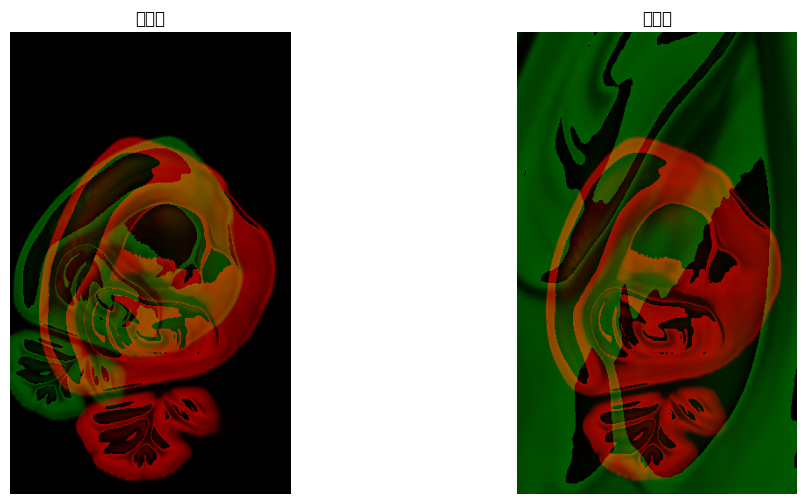

In [6]:

transformed_m1 = register_with_intensity(A, A1)


show_overlay_comparison(A, A1, transformed_m1)